In [1]:
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


In [2]:
def preprocess_data(data, target_col, discrete_cols, past_steps=96, future_steps=96):
    """
    数据预处理：包括离散特征编码、时间序列切片。
    """
    label_encoders = {col: LabelEncoder() for col in discrete_cols}
    for col in discrete_cols:
        data[col] = label_encoders[col].fit_transform(data[col])

    scaler = MinMaxScaler()
    continuous_cols = [col for col in data.columns if col not in discrete_cols + [target_col]]
    data[continuous_cols + [target_col]] = scaler.fit_transform(data[continuous_cols + [target_col]])

    X_cont, X_cat, y = [], [], []
    for i in range(len(data) - past_steps - future_steps):
        X_cont.append(data.iloc[i:i+past_steps][continuous_cols].values)
        X_cat.append(data.iloc[i:i+past_steps][discrete_cols].values)
        y.append(data.iloc[i+past_steps:i+past_steps+future_steps][target_col].values)

    return np.array(X_cont), np.array(X_cat), np.array(y), label_encoders, scaler



In [3]:
train_data = pd.read_csv('train_data.csv').dropna()
test_data = pd.read_csv('test_data.csv').dropna()

# 删除无关列
train_data.drop(['dteday', 'instant'], axis=1, inplace=True)
test_data.drop(['dteday', 'instant'], axis=1, inplace=True)

# 指定离散列
discrete_cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']

# 数据预处理
X_cont_train, X_cat_train, y_train, label_encoders, scaler = preprocess_data(train_data, 'cnt', discrete_cols)
X_cont_test, X_cat_test, y_test, _, _ = preprocess_data(test_data, 'cnt', discrete_cols)

# 转换为 Tensor
X_cont_train_tensor = torch.tensor(X_cont_train, dtype=torch.float32)
X_cat_train_tensor = torch.tensor(X_cat_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_cont_test_tensor = torch.tensor(X_cont_test, dtype=torch.float32)
X_cat_test_tensor = torch.tensor(X_cat_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 创建 DataLoader
batch_size = 16
train_dataset = TensorDataset(X_cont_train_tensor, X_cat_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_cont_test_tensor, X_cat_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [4]:
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, lstm_hidden_dim, output_dim):
        super(CNNLSTM, self).__init__()
        self.conv = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=kernel_size//2)
        self.lstm = nn.LSTM(hidden_dim, lstm_hidden_dim, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # 调整维度 (batch, channels, seq_len)
        x = F.relu(self.conv(x))
        x = x.permute(0, 2, 1)  # 调整回原始维度 (batch, seq_len, channels)
        x, _ = self.lstm(x)
        return self.fc(x[:, -1, :])  # 取最后时间步输出

# 初始化模型
input_dim = X_cont_train.shape[2]  # 连续特征数量
hidden_dim = 64
kernel_size = 3
lstm_hidden_dim = 128
output_dim = y_train.shape[1]  # 预测步长
model = CNNLSTM(input_dim, hidden_dim, kernel_size, lstm_hidden_dim, output_dim)


In [5]:
criterion = nn.MSELoss()
mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
def train_model(model, train_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_cont_batch, _, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_cont_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer, epochs=20)



Epoch 1/20, Train Loss: 0.0098
Epoch 2/20, Train Loss: 0.0087
Epoch 3/20, Train Loss: 0.0075
Epoch 4/20, Train Loss: 0.0067
Epoch 5/20, Train Loss: 0.0061
Epoch 6/20, Train Loss: 0.0058
Epoch 7/20, Train Loss: 0.0054
Epoch 8/20, Train Loss: 0.0054
Epoch 9/20, Train Loss: 0.0049
Epoch 10/20, Train Loss: 0.0047
Epoch 11/20, Train Loss: 0.0047
Epoch 12/20, Train Loss: 0.0047
Epoch 13/20, Train Loss: 0.0047
Epoch 14/20, Train Loss: 0.0040
Epoch 15/20, Train Loss: 0.0042
Epoch 16/20, Train Loss: 0.0043
Epoch 17/20, Train Loss: 0.0050
Epoch 18/20, Train Loss: 0.0038
Epoch 19/20, Train Loss: 0.0035
Epoch 20/20, Train Loss: 0.0035


torch.Size([96, 6])
Test Loss: 0.0208
MAE: 62.1992 ± 23.7556
MSE: 8688.6918 ± 6309.1122


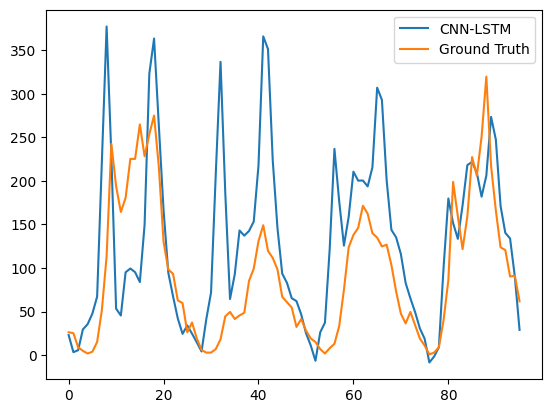

In [8]:
# %% 测试模型

def evaluate_model(model, test_loader, criterion, scaler, target_col_index=-1):
    model.eval()
    test_loss = 0.0
    predictions, targets = [], []
    features=[]
    allMae = []
    allMse = []
    with torch.no_grad():
        for X_cont_batch, _, y_batch in test_loader:
            for i in range(len(X_cont_batch)):
                features.append(X_cont_batch[i])
            outputs = model(X_cont_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            #inverse_transform
            predictions.append(outputs)
            targets.append(y_batch)

    # 转换为数组
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    print(features[0].shape)
    for i in range(len(predictions)):
        t1=torch.tensor(predictions[i]).reshape(-1,1)
        t2=torch.tensor(targets[i]).reshape(-1,1)
        whole1=torch.cat((features[i],t1),dim=1)
        whole2=torch.cat((features[i],t2),dim=1)
        whole1=scaler.inverse_transform(whole1)
        whole2=scaler.inverse_transform(whole2)
        predictions[i]=whole1[:,-1]
        targets[i]=whole2[:,-1]
        allMae.append(mae(torch.tensor(predictions[i]),torch.tensor(targets[i])).item())
        allMse.append(criterion(torch.tensor(predictions[i]),torch.tensor(targets[i])).item())
    print(f"Test Loss: {test_loss / len(test_loader):.4f}")

    return predictions, targets, allMae, allMse


# 调用 evaluate_model
predictions, targets,allMae,allMse = evaluate_model(model, test_loader, criterion, scaler)
selected_maes = []
selected_mses = []
for i in range(5):
    idx=random.randint(0,len(predictions)-1)
    selected_maes.append(allMae[idx])
    selected_mses.append(allMse[idx])
mae_std = np.std(selected_maes)
mse_std = np.std(selected_mses)
print(f"MAE: {np.mean(selected_maes):.4f} ± {mae_std:.4f}")
print(f"MSE: {np.mean(selected_mses):.4f} ± {mse_std:.4f}")

import matplotlib.pyplot as plt
plt.plot(predictions[-1], label='CNN-LSTM')
plt.plot(targets[-1], label='Ground Truth')
plt.legend()
plt.show()